In [1]:
import gmmreg
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scipy.spatial as spat

Load the good frames

In [2]:
frames=np.load("./data/peaks/cleaned-test.npy",allow_pickle=True)
roughims=np.zeros((len(frames),58,38))
for i,frame in enumerate(frames):
    for pt in frame:
        roughims[i,int(pt[0]/5),int(pt[1]/5)]+=1

Perform PCA to separate the rough posture

In [3]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(roughims.reshape(len(frames),-1))

We can either sample uniformly the reference frames or sample it uniformly in PCA space. In this case, it does not seem to matter a lot.

In [4]:
def random_target_space_sampling(embedding,num,thres=0.05):
    dim=embedding.shape[1]
    inds=[]
    lowbds=np.min(embedding,axis=0)
    uppbds=np.max(embedding,axis=0)
    for i in range(dim):
        embedding[:,i]=(embedding[:,i]-lowbds[i])/(uppbds[i]-lowbds[i])
    tree=spat.cKDTree(embedding)
    while(len(inds)!=num):
        ind=np.random.rand(dim)
        d,i=tree.query(ind)
        if d<thres:
            inds.append(i)
    return inds

In [5]:
inds=random_target_space_sampling(pca_result,200)

'\nfor i,frame in enumerate(frames):\n    if np.random.random()<0.1:\n        plt.annotate(i,pca_result[i,0:2])\n'

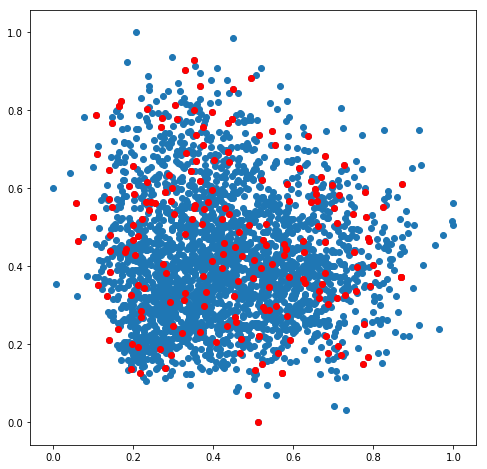

In [6]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:,0],pca_result[:,1])
for ind in inds:
    plt.scatter(pca_result[ind,0],pca_result[ind,1],c="r")
"""
for i,frame in enumerate(frames):
    if np.random.random()<0.1:
        plt.annotate(i,pca_result[i,0:2])
"""

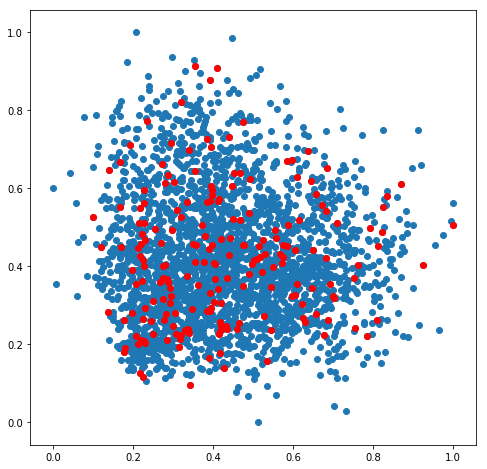

In [7]:
plt.figure(figsize=(8,8))
plt.scatter(pca_result[:,0],pca_result[:,1])
inds2=np.random.choice(np.arange(len(pca_result)),size=200,replace=False)
for ind in inds2:
    plt.scatter(pca_result[ind,0],pca_result[ind,1],c="r")

The straightening is not enough to remove all small residual motions. Thin Plate Spline method is further applied to fit these points.

Now Create References: inds for PCA-uniform references, inds2 for random references

In [62]:
references=[]
for ind in inds2:
    references.append(frames[ind])
print(len(references),"references")
kdtrees=[]
for reference in references:
    kdtrees.append(spat.cKDTree(reference))

200 references


Use the TPS implementation of  https://github.com/bing-jian/gmmreg-python. There was a memory leak which I fixed here.

In [100]:
frame=frames[np.random.randint(0,len(frames))]
allrefmatches=[]
for r,(reference,kdtree) in enumerate(zip(references,kdtrees)):
    print("\r Reference:",r,end="")
    _, _, after_tps=gmmreg.run_numpy(frame,reference,level=3,sigmas=[0.4,0.1,0.05],lambdas=[0.02,0.009,0.005])
    allrefmatches.append(after_tps)

 Reference: 199

Plot the result, a hyperparameter search is definitely needed.

(0, 190)

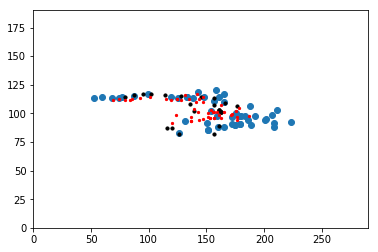

In [106]:
plt.scatter(*frame[:,:2].T)
r=np.random.randint(0,len(allrefmatches))
plt.scatter(*references[r][:,:2].T,c="black",s=10)
plt.scatter(*allrefmatches[r][:,:2].T,c="r",s=5)
plt.xlim(0,290)
plt.ylim(0,190)

Do it for all frames. Note that we use a kdtree query from reference to actually get the neuron registration vector

In [107]:
wholerefmatches=[]
for i,frame in enumerate(frames):
    try:
        print("Frame",i)
        allrefmatches=[]
        for pt in frame:
            allrefmatches.append([])
        for r,(reference,kdtree) in enumerate(zip(references,kdtrees)):
            print("\r Reference:",r,end="")
            _, _, after_tps=gmmreg.run_numpy(frame,reference,level=3,sigmas=[0.4,0.1,0.05],lambdas=[0.02,0.009,0.005])
            #print(len(after_tps))
            for j,pt in enumerate(after_tps):
                d,l=kdtree.query(pt,k=1)
                if d<4:
                    allrefmatches[j].append(l)
                else:
                    allrefmatches[j].append(-1)
        wholerefmatches.append(np.array(allrefmatches))
    except KeyboardInterrupt:
        np.save("./data/testingandys/wholerefmatches.npy",wholerefmatches)
        break
    except:
        wholerefmatches.append(None)
    if (i+1)%30==0:
        np.save("./data/testingandys/wholerefmatches.npy",wholerefmatches)
np.save("./data/testingandys/wholerefmatches.npy",wholerefmatches)

Frame 0
 Reference: 199Frame 1
 Reference: 199Frame 2
 Reference: 199Frame 3
 Reference: 199Frame 4
 Reference: 199Frame 5
 Reference: 199Frame 6
 Reference: 199Frame 7
 Reference: 199Frame 8
 Reference: 199Frame 9
 Reference: 199Frame 10
 Reference: 199Frame 11
 Reference: 199Frame 12
 Reference: 199Frame 13
 Reference: 199Frame 14
 Reference: 199Frame 15
 Reference: 199Frame 16
 Reference: 199Frame 17
 Reference: 199Frame 18
 Reference: 199Frame 19
 Reference: 199Frame 20
 Reference: 199Frame 21
 Reference: 199Frame 22
 Reference: 199Frame 23
 Reference: 199Frame 24
 Reference: 199Frame 25
 Reference: 199Frame 26
 Reference: 199Frame 27
 Reference: 199Frame 28
 Reference: 199Frame 29
 Reference: 199Frame 30
 Reference: 199Frame 31
 Reference: 199Frame 32
 Reference: 199Frame 33
 Reference: 199Frame 34
 Reference: 199Frame 35
 Reference: 199Frame 36
 Reference: 199Frame 37
 Reference: 199Frame 38
 Reference: 199Frame 39
 Reference: 199Frame 40
 Reference: 199Frame 41
 Reference: 199Fr

 Reference: 199Frame 657
 Reference: 199Frame 658
 Reference: 199Frame 659
 Reference: 199Frame 660
 Reference: 199Frame 661
 Reference: 199Frame 662
 Reference: 199Frame 663
 Reference: 199Frame 664
 Reference: 199Frame 665
 Reference: 199Frame 666
 Reference: 199Frame 667
 Reference: 199Frame 668
 Reference: 199Frame 669
 Reference: 199Frame 670
 Reference: 199Frame 671
 Reference: 199Frame 672
 Reference: 199Frame 673
 Reference: 199Frame 674
 Reference: 199Frame 675
 Reference: 199Frame 676
 Reference: 1991 3781Frame 677
 Reference: 199Frame 678
 Reference: 199Frame 679
 Reference: 199Frame 680
 Reference: 199Frame 681
 Reference: 199Frame 682
 Reference: 199Frame 683
 Reference: 199Frame 684
 Reference: 199Frame 685
 Reference: 199Frame 686
 Reference: 199Frame 687
 Reference: 199Frame 688
 Reference: 199Frame 689
 Reference: 199Frame 690
 Reference: 199Frame 691
 Reference: 199Frame 692
 Reference: 199Frame 693
 Reference: 199Frame 694
 Reference: 199Frame 695
 Reference: 199Fram

 Reference: 199Frame 1297
 Reference: 199Frame 1298
 Reference: 1996 187Frame 1299
 Reference: 199Frame 1300
 Reference: 199Frame 1301
 Reference: 1993Frame 1302
 Reference: 199Frame 1303
 Reference: 199Frame 1304
 Reference: 199Frame 1305
 Reference: 199Frame 1306
 Reference: 199Frame 1307
 Reference: 199Frame 1308
 Reference: 199Frame 1309
 Reference: 199Frame 1310
 Reference: 199Frame 1311
 Reference: 199Frame 1312
 Reference: 199Frame 1313
 Reference: 199Frame 1314
 Reference: 199Frame 1315
 Reference: 199Frame 1316
 Reference: 199Frame 1317
 Reference: 199Frame 941318
 Reference: 199Frame 1319
 Reference: 199Frame 1320
 Reference: 199Frame 1321
 Reference: 199Frame 1322
 Reference: 199Frame 1323
 Reference: 199Frame 1324
 Reference: 199Frame 1325
 Reference: 199Frame 1326
 Reference: 199Frame 1327
 Reference: 1996Frame 1328
 Reference: 199Frame 1329
 Reference: 199Frame 1330
 Reference: 199Frame 1331
 Reference: 199Frame 1332
 Reference: 199Frame 1333
 Reference: 199Frame 1334
 Re

 Reference: 199Frame 1921
 Reference: 199Frame 1922
 Reference: 199Frame 1923
 Reference: 199Frame 1924
 Reference: 199Frame 1925
 Reference: 199Frame 1926
 Reference: 199Frame 1927
 Reference: 199Frame 1928
 Reference: 199Frame 1929
 Reference: 199Frame 1930
 Reference: 199Frame 1931
 Reference: 199Frame 1932
 Reference: 199Frame 1933
 Reference: 199Frame 1934
 Reference: 199Frame 1935
 Reference: 199Frame 1936
 Reference: 199Frame 1937
 Reference: 199Frame 1938
 Reference: 199Frame 1939
 Reference: 199Frame 1940
 Reference: 199Frame 1941
 Reference: 1999Frame 1942
 Reference: 199Frame 1943
 Reference: 199Frame 1944
 Reference: 199Frame 1945
 Reference: 199Frame 1946
 Reference: 199Frame 1947
 Reference: 199Frame 1948
 Reference: 199Frame 1949
 Reference: 199Frame 1950
 Reference: 199Frame 1951
 Reference: 199Frame 1952
 Reference: 199Frame 1953
 Reference: 199Frame 1954
 Reference: 199Frame 1955
 Reference: 199Frame 1956
 Reference: 199Frame 1957
 Reference: 199Frame 1958
 Reference:

 Reference: 199Frame 2549
 Reference: 1997Frame 2550
 Reference: 199Frame 2551
 Reference: 199Frame 2552
 Reference: 199Frame 2553
 Reference: 199Frame 2554
 Reference: 199Frame 2555
 Reference: 199Frame 2556
 Reference: 199Frame 2557
 Reference: 199Frame 2558
 Reference: 199Frame 2559
 Reference: 199Frame 2560
 Reference: 199Frame 2561
 Reference: 199Frame 2562
 Reference: 199Frame 2563
 Reference: 199Frame 2564
 Reference: 199Frame 2565
 Reference: 199Frame 2566
 Reference: 199Frame 2567
 Reference: 199Frame 2568
 Reference: 199Frame 2569
 Reference: 199Frame 2570
 Reference: 199Frame 2571
 Reference: 199Frame 2572
 Reference: 199Frame 2573
 Reference: 199Frame 2574
 Reference: 199Frame 2575
 Reference: 199Frame 2576
 Reference: 199Frame 2577
 Reference: 1992Frame 2578
 Reference: 199Frame 2579
 Reference: 199Frame 2580
 Reference: 199Frame 2581
 Reference: 199Frame 2582
 Reference: 199Frame 2583
 Reference: 199Frame 2584
 Reference: 199Frame 2585
 Reference: 199Frame 2586
 Reference

save it

In [108]:
np.save("./data/testingandys/wholerefmatches.npy",wholerefmatches)